Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

###Wrangle the Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
full_train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train and val
train, val = train_test_split(full_train,train_size=0.80, test_size=.20,
                              stratify=full_train['status_group'], random_state=7)

train.shape, val.shape, test.shape, full_train.shape

((47520, 41), (11880, 41), (14358, 40), (59400, 41))

In [0]:
import numpy as np

def wrangle(X):

  # make a copy to avoid messing with the data
  X = X.copy()

  #replace the tiny value with 0
  X['latitude'] =X['latitude'].replace(-2e-08, 0)

  # replace 0s with nulls so that they can be imputed later
  cols_with_zeros = ['longitude','latitude','construction_year',
                     'gps_height','population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  
  # drop duplicates
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

  # recorded_by is all the same so I'm dropping it
  # and id isn't very helpful either
  X = X.drop(columns=['recorded_by','id'])
  
  #convert date_recorded and to date data type
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  
  # convert the date_recorded to year, month, and day column 
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # add an age_at_inspection column
  X['age_at_inspection'] = X['year_recorded'] - X['construction_year']

  #return the wrangled dataframe
  return X

#use the function on the data sets
w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)
w_full_train = wrangle(full_train)

In [0]:
# set target and features
target = 'status_group'

train_features = w_train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
high_cardinality = cardinality[cardinality > 50].index.tolist()

subfeatures = numeric_features + categorical_features
features = subfeatures + high_cardinality

In [6]:
# Arrange features into X features matrix and y target vector
X_full_train = w_full_train[subfeatures]
y_full_train = w_full_train[target]
X_train = w_train[subfeatures]
y_train = w_train[target]
X_val = w_val[subfeatures]
y_val = w_val[target]
X_test = w_test[subfeatures]


print(train.shape,val.shape)
print(X_train.shape,X_val.shape)

(47520, 41) (11880, 41)
(47520, 37) (11880, 37)


In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [20]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs=-1, random_state=7, max_depth=20, n_estimators=291)
)

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', pipeline.score(X_val,y_val))

Validation Accuracy: 0.8166666666666667
CPU times: user 44.4 s, sys: 299 ms, total: 44.7 s
Wall time: 23.4 s


###Plot a confusion matrix for your Tanzania Waterpumps model.

In [9]:
!pip install scikit-plot

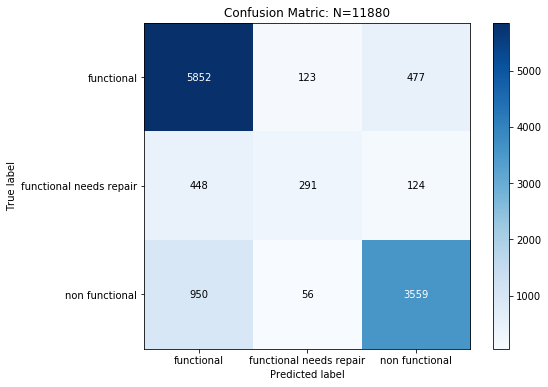

In [21]:
from scikitplot.metrics import plot_confusion_matrix

# submission 6
plot_confusion_matrix(y_val, y_pred,
                      figsize=(8,6),
                      title=f"Confusion Matric: N={len(y_val)}",
                      normalize=False);

### Add a column that shows the probability of predicting the target

In [23]:
# Merge train_features.csv & train_labels.csv
full_train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
full_train['y_pred_proba'] = pipeline.predict_proba(X_full_train)[:,1]

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train and val
train, val = train_test_split(full_train,train_size=0.80, test_size=.20,
                              stratify=full_train['status_group'], random_state=7)

train.shape, val.shape, test.shape, full_train.shape

((47520, 42), (11880, 42), (14358, 40), (59400, 42))

In [0]:
import numpy as np

def wrangle(X):

  # make a copy to avoid messing with the data
  X = X.copy()

  #replace the tiny value with 0
  X['latitude'] =X['latitude'].replace(-2e-08, 0)

  # replace 0s with nulls so that they can be imputed later
  cols_with_zeros = ['longitude','latitude','construction_year',
                     'gps_height','population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  
  # drop duplicates
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

  # recorded_by is all the same so I'm dropping it
  # and id isn't very helpful either
  X = X.drop(columns=['recorded_by','id'])
  
  #convert date_recorded and to date data type
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  
  # convert the date_recorded to year, month, and day column 
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # add an age_at_inspection column
  X['age_at_inspection'] = X['year_recorded'] - X['construction_year']

  #return the wrangled dataframe
  return X

#use the function on the data sets
w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)
w_full_train = wrangle(full_train)

In [0]:
# set target and features
target = 'status_group'

train_features = w_train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
high_cardinality = cardinality[cardinality > 50].index.tolist()

subfeatures = numeric_features + categorical_features
features = subfeatures + high_cardinality

In [27]:
# Arrange features into X features matrix and y target vector
X_full_train = w_full_train[subfeatures]
y_full_train = w_full_train[target]
X_train = w_train[subfeatures]
y_train = w_train[target]
X_val = w_val[subfeatures]
y_val = w_val[target]


print(train.shape,val.shape)
print(X_train.shape,X_val.shape)

(47520, 42) (11880, 42)
(47520, 38) (11880, 38)


In [28]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs=-1, random_state=7, max_depth=20, n_estimators=291)
)

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', pipeline.score(X_val,y_val))

Validation Accuracy: 0.8102693602693603
CPU times: user 47.5 s, sys: 276 ms, total: 47.8 s
Wall time: 25 s


### Show the new Confusion Matrix

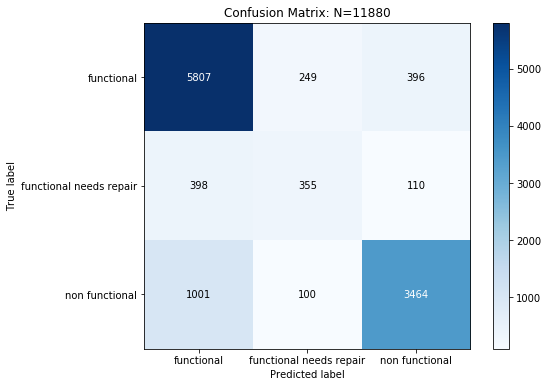

In [30]:
plot_confusion_matrix(y_val, y_pred,
                      figsize=(8,6),
                      title=f"Confusion Matrix: N={len(y_val)}",
                      normalize=False);

###Continue to participate in our Kaggle challenge.
###Submit your final predictions to our Kaggle competition. 
####Optionally, go to My Submissions, and "you may select up to 1 submission to be used to count towards your final leaderboard score."

In [31]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group']=y_pred
submission.to_csv('submission_7.csv',index=False)

ValueError: ignored

###Commit your notebook to your fork of the GitHub repo.